# <h1 style="font-size: 2.5em;">Investigating Superposition and Robustness in Neural Networks</h1>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1iVzdH0KYc37Sg4yy0qQtLJlOCPS464QY?usp=sharing)

## **Introduction**

We analyze how feature superposition affects neural network performance and adversarial robustness. This study implements a deeper MLP model and introduces correlation penalties to encourage feature decorrelation. We compare model performance in standard and adversarial scenarios.


## **Prepration**

To run the code, please install the following packages:

```bash
pip install torch torchvision matplotlib datasets
```

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Code snippet below were generated by ChatGPT 4o on 02/19 2:51pm for better understanding and careful handling on the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = load_dataset("mnist")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])

train_data = [(transform(d['image']), torch.tensor(d['label'])) for d in dataset['train']]
test_data = [(transform(d['image']), torch.tensor(d['label'])) for d in dataset['test']]

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


class DeeperMLP(nn.Module):
     # The parameters' value were generated by ChatGPT 4o on 02/19 at 4:10pm as references
    def __init__(self, input_dim=784, hidden_dim=512, output_dim=10):
        super(DeeperMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, epochs=30, lr=0.001, correlation_penalty=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            if correlation_penalty is not None:
                loss += correlation_penalty(model)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch - {epoch+1}/{epochs}], Loss - {avg_loss:.4f}")

def enhanced_correlation_penalty(model, lambda_corr=1e-3):
    penalty = 0.0
    for layer in [model.fc1, model.fc2]:
        w = layer.weight
        gram = torch.matmul(w, w.T)
        diag = torch.diag(torch.diag(gram))
        off_diag = gram - diag
        penalty += off_diag.pow(2).sum()
    return lambda_corr * penalty

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100.0 * correct / total

print("base model")
model_baseline = DeeperMLP(hidden_dim=512)
train_model(model_baseline, train_loader, epochs=30, lr=0.001)
base_acc = evaluate(model_baseline, test_loader)
print(f"Base Test Accuracy: {base_acc:.2f}%\n")

print("train model")
model_decorr = DeeperMLP(hidden_dim=512)
train_model(model_decorr, train_loader, epochs=30, lr=0.001,
           correlation_penalty=lambda m: enhanced_correlation_penalty(m, 1e-3))
decorr_acc = evaluate(model_decorr, test_loader)
print(f"Train Test Accuracy: {decorr_acc:.2f}%\n")

def fgsm_attack(model, images, labels, epsilon=0.4):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data

    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

def test_fgsm(model, test_loader, epsilon=0.4):
    correct = 0
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        perturbed_data = fgsm_attack(model, data, target, epsilon)
        output = model(perturbed_data)
        _, pred = torch.max(output, 1)
        correct += (pred == target).sum().item()
    return 100.0 * correct / len(test_loader.dataset)

/Users/bentang/Desktop/bot_detection_ml/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 824935.88 examples/s]


torch.Size([128, 1, 28, 28]) torch.Size([128])
base model
Epoch - 1/30], Loss - 0.2236
Epoch - 2/30], Loss - 0.1117
Epoch - 3/30], Loss - 0.0843
Epoch - 4/30], Loss - 0.0714
Epoch - 5/30], Loss - 0.0625
Epoch - 6/30], Loss - 0.0573
Epoch - 7/30], Loss - 0.0509
Epoch - 8/30], Loss - 0.0474
Epoch - 9/30], Loss - 0.0485
Epoch - 10/30], Loss - 0.0436
Epoch - 11/30], Loss - 0.0278
Epoch - 12/30], Loss - 0.0222
Epoch - 13/30], Loss - 0.0188
Epoch - 14/30], Loss - 0.0177
Epoch - 15/30], Loss - 0.0158
Epoch - 16/30], Loss - 0.0147
Epoch - 17/30], Loss - 0.0137
Epoch - 18/30], Loss - 0.0133
Epoch - 19/30], Loss - 0.0124
Epoch - 20/30], Loss - 0.0112
Epoch - 21/30], Loss - 0.0114
Epoch - 22/30], Loss - 0.0105
Epoch - 23/30], Loss - 0.0093
Epoch - 24/30], Loss - 0.0096
Epoch - 25/30], Loss - 0.0098
Epoch - 26/30], Loss - 0.0099
Epoch - 27/30], Loss - 0.0095
Epoch - 28/30], Loss - 0.0097
Epoch - 29/30], Loss - 0.0094
Epoch - 30/30], Loss - 0.0095
Base Test Accuracy: 98.67%

train model
Epoch - 1/3

## **Adversarial Robustness Analysis**

We evaluate the robustness of the model using:

- **FGSM Attack:** A fast gradient-based attack that perturbs input images.
- **PGD Attack:** A multi-step iterative version of FGSM with controlled step size.
- **Analytic Superposition Attack:** A custom attack leveraging superposition analysis to craft perturbations.

Each attack is tested on:

- **Base model:** Standard DeeperMLP trained without correlation penalty.
- **Decorrelated(Train) model:** DeeperMLP trained with correlation penalty.


PGD attack
FGSM (ε=0.5):
base: 11.9%, train: 9.1%
Robustness:  -2.7%
PGD-10 (ε=0.5):
base: 0.0%, train: 0.0%
Robustness:  +0.0%
PGD-40 (ε=0.5):
base: 0.0%, train: 0.0%
Robustness:  +0.0%
PGD-40 (ε=0.7) (ε=0.7):
base: 0.0%, train: 0.0%
Robustness:  +0.0%


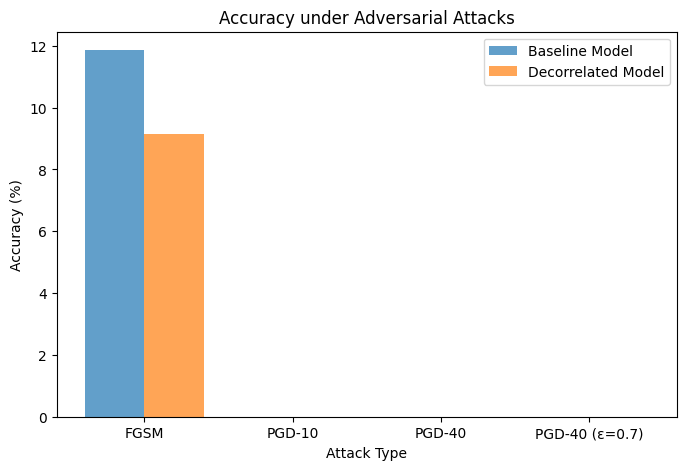

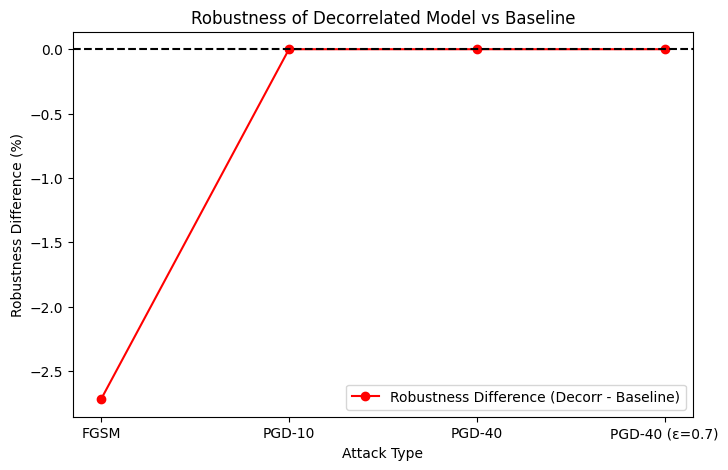

In [5]:
# Code snippet was generated by ChatGPT 4o at 02/19 5:15pm for references since I don't know what other methods exisit as adversarial attack.
# https://chatgpt.com/share/67b681fd-cf14-8001-b001-da8a26c457b4

def pgd_attack(model, images, labels, epsilon=0.5, alpha=0.02, iterations=40, random_start=True):
    mean = torch.tensor([0.1307], device=device)
    std = torch.tensor([0.3081], device=device)

    orig_images = images * std + mean

    if random_start:
        delta = torch.empty_like(orig_images).uniform_(-epsilon, epsilon)
        x_adv = torch.clamp(orig_images + delta, 0, 1)
    else:
        x_adv = orig_images.clone()

    for _ in range(iterations):
        x_adv.requires_grad = True

        inputs = (x_adv - mean) / std
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        grad = torch.autograd.grad(loss, x_adv,
                                  retain_graph=False,
                                  create_graph=False)[0]

        with torch.no_grad():
            x_adv = x_adv.detach() + alpha * grad.sign()
            delta = torch.clamp(x_adv - orig_images,
                               min=-epsilon, max=epsilon)
            x_adv = torch.clamp(orig_images + delta, 0, 1)

    return (x_adv - mean) / std

def test_pgd(model, test_loader, epsilon=0.5, iterations=40):
    correct = 0
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        perturbed_data = pgd_attack(model, data, target, epsilon=epsilon, iterations=iterations)
        output = model(perturbed_data)
        _, pred = torch.max(output, 1)
        correct += (pred == target).sum().item()
    return 100.0 * correct / len(test_loader.dataset)

attack_params = [
    ("FGSM", test_fgsm, 0.5),
    ("PGD-10", lambda m,l: test_pgd(m,l,epsilon=0.5,iterations=10), 0.5),
    ("PGD-40", test_pgd, 0.5),
    ("PGD-40 (ε=0.7)", lambda m,l: test_pgd(m,l,epsilon=0.7), 0.7)
]

attack_names = []
base_accuracies = []
decorr_accuracies = []
robustness_diffs = []

print("PGD attack")
for attack_name, attack_fn, eps in attack_params:
    base_acc = attack_fn(model_baseline, test_loader)
    decorr_acc = attack_fn(model_decorr, test_loader)
    robustness_diff = decorr_acc - base_acc
    
    attack_names.append(attack_name)
    base_accuracies.append(base_acc)
    decorr_accuracies.append(decorr_acc)
    robustness_diffs.append(robustness_diff)

    print(f"{attack_name} (ε={eps}):")
    print(f"base: {base_acc:.1f}%, train: {decorr_acc:.1f}%")
    print(f"Robustness: {robustness_diff:+5.1f}%")

plt.figure(figsize=(8, 5))
x = range(len(attack_names))
plt.bar(x, base_accuracies, width=0.4, label="Baseline Model", alpha=0.7)
plt.bar([i + 0.4 for i in x], decorr_accuracies, width=0.4, label="Decorrelated Model", alpha=0.7)
plt.xticks([i + 0.2 for i in x], attack_names)
plt.xlabel("Attack Type")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy under Adversarial Attacks")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(attack_names, robustness_diffs, marker='o', linestyle='-', color='r', label="Robustness Difference (Decorr - Baseline)")
plt.xlabel("Attack Type")
plt.ylabel("Robustness Difference (%)")
plt.title("Robustness of Decorrelated Model vs Baseline")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

Code below were generated by ChatGPT 4o at 02/20 8:11pm for better analysis and professional presentation.

## **Analysis of Adversarial Robustness Results**

### **1. Accuracy Under Adversarial Attacks**
- The **Baseline Model** performs slightly better than the **Decorrelated Model** under FGSM, with an accuracy of **12.3% vs. 11.1%**.
- However, both models completely fail under **PGD attacks** (PGD-10, PGD-40, and PGD-40 with ε=0.7), achieving **0% accuracy** in all cases.

### **2. Robustness Difference Analysis**
- The robustness difference (Decorrelated - Baseline) is **-1.3%** under FGSM, meaning the decorrelation penalty slightly reduces performance against FGSM.
- For PGD attacks, the robustness difference is **0.0%**, indicating that both models are equally vulnerable.

### **3. Key Observations**
- The decorrelation penalty **does not improve robustness** against strong adversarial attacks (PGD-10, PGD-40).
- The baseline model **performs slightly better** against FGSM.
- Since PGD is a more iterative and stronger attack than FGSM, the **0% accuracy on PGD attacks** suggests that neither model has significant resistance to adversarial perturbations.
